<a href="https://colab.research.google.com/github/shinb-bong/TIL/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN(Generative Adversarial Network)
----

모델 1 vs 모델 2 을 시합시킴

- 데이터 생성하는 딥러닝 모델 만들기 가능

Generator model + Discriminator 모델

- 가짜 데이터 생성 + 데이터를 검증하는 역할 
- 어느순간 검증했을때 잘만들었다고 판단이 나옴

그러면 이제 Generator 모델 사용

GAN 프로젝트
1. Human face 생성
-> Generator 
- 랜덤한 숫자(행렬)를 입력하면 사람 얼굴 이미지를 내뱉는 모델
- 내뱉는건 이미지가 아닌 64x64x3의 행렬

-> Disciminator 
- 이미지를 입력하면 진짜면 1 가짜면 0

합치려면 똑같이 Sequential([Generator , Discriminator])

하지만 학습 방법이 조금 다름

1. Disciminator 먼저 학습
- 실제 사람이미지, 가짜 이미지 준비(아무거나 행렬)
- 진짜 이미지는 1로 아닌건 0으로
- train_on_batch(이미지,정답)

2. Generator 학습
- 랜덤 숫자 행렬 100개 준비 , 1로 라벨링 집어 넣기


결론:

랜덤 숫자가 들어와서 Generator 을 거치면 새로운 가짜 이미지를 준다. 하지만 그것을 정답 라벨링을 하면 Discriminator는 해당 사진을 보고 loss를 추론한다.

하지만 궁극적인 목표인 loss를 줄이기 위해서 Generator가 진짜 같은 이미지를 생산하면 줄여진다. => Disciminator가 진짜라고 속았을때

그렇게 되려면 Generator의 w값들은 총 loss를 줄이려면 더욱더 진짜 같은 사람을 생성하는 w값으로 점점 변하게된다.


----

그 외에도 GAN은 종류가 여러개다.



In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "drive/MyDrive/" 
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip -q celeba-dataset.zip -d .

 99% 1.32G/1.33G [00:07<00:00, 160MB/s]
100% 1.33G/1.33G [00:07<00:00, 194MB/s]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


이미지 숫자화 및 흑백사진

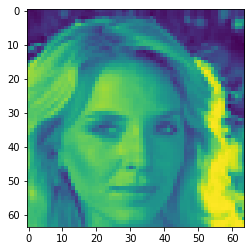

(50000, 64, 64)


In [14]:
from PIL import Image
import numpy as np
import os 
fileList = os.listdir('img_align_celeba/img_align_celeba')

images = []

# 예시 사진 하나씩 다 숫자화
for i in fileList[0:50000]:
  num_img = Image.open('img_align_celeba/img_align_celeba/'+i).crop((20,30,160,180)).convert('L').resize((64,64))
  images.append( np.array(num_img))

# 시간 절약을 위해 흑백으로 진행
import matplotlib.pyplot as plt
plt.imshow(images[1])
plt.show()

images = np.array(images)
print(images.shape)



이미지 전처리
4차원 행렬

In [16]:
images = np.divide(images,255)
images = images.reshape(50000,64,64,1)
print(images.shape)

(50000, 64, 64, 1)


Discriminator
---
이미지를 입력하면 진짜/가짜 판정해줌

LeakyReLu 는 음의 값에 작은 숫자를 곱해주고
ReLU는 음의 값을 다 0으로 바꿔준다.

In [18]:
import tensorflow as tf

discriminator = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=[64,64,1]),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  # 아웃풋 주의 node = 1 
  tf.keras.layers.Dense(1, activation='sigmoid')
])

Generator
---

- Dense
- Conv2D: 특성 추출 + 사이즈 키우기 => Conv2DTranspose레이어

In [19]:
noise_shape = 100

generator = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4 * 4 * 256, input_shape=(100,) ), 
  tf.keras.layers.Reshape((4, 4, 256)),
  tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same'),
  tf.keras.layers.LeakyReLU(alpha=0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        590080    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)     

GAN 전체 모델 완성
---

1. discriminator 트레이닝 => discriminartor 컴파일
2. generator 트레이닝 -> GAN 컴파일

In [21]:
GAN = tf.keras.models.Sequential([
                                  generator, discriminator
])

discriminator.compile(optimizer='adam', loss='binary_crossentropy')
# 중요! 얘는 계속 학습되면 안됨
discriminator.trainable = False

GAN.compile(optimizer='adam', loss='binary_crossentropy')


GAN에 랜덤 숫자를 넣어서 이미지가 발생하는지 보여주는 함수
----
랜덤한숫자를 넣으면 진짜 이미지가 나오는가? 

np는 늘 뒤부터 읽는다 
100개짜리를 8세트 뽑아주세요

In [33]:
def predict_pic():

  rand_num = np.random.uniform(-1,1, size = (10,100) ) 
  result = generator.predict(rand_num)

  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(result[i].reshape(64,64), cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

아직 generator은 trainning이 되지 않은 상태
진짜 사진만 먼저 학습하면 편향 될 수도 있음 => 방안 생각


Generator 학습 및 작동
---

지금 epoch: 0


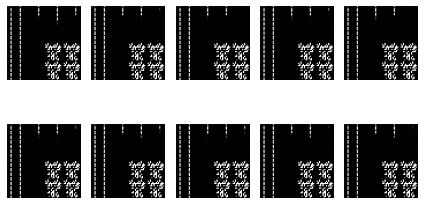

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.4005319371790392e-05 GAN 13.77851676940918
지금 epoch: 1


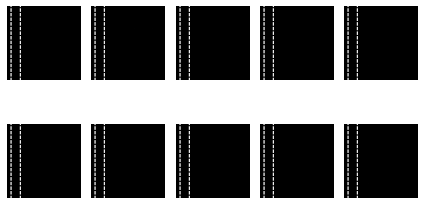

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.4352076649665833 GAN 0.7484886646270752
지금 epoch: 2


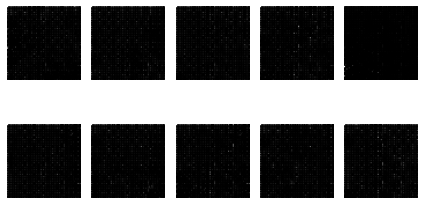

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.03771214000880718 GAN 0.08255668729543686
지금 epoch: 3


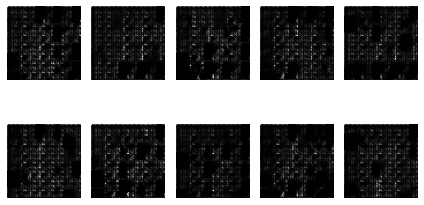

지금 batch: 0
지금 batch: 100
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.0402389168739319 GAN 1.9535112380981445
지금 epoch: 4


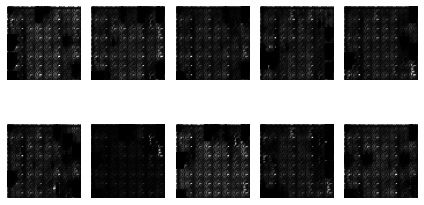

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.6806493997573853 GAN 1.869418740272522
지금 epoch: 5


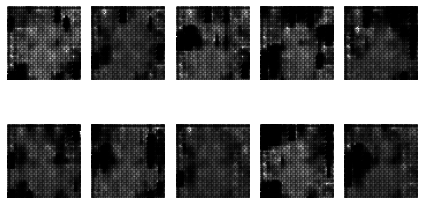

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.4909825325012207 GAN 0.7130539417266846
지금 epoch: 6


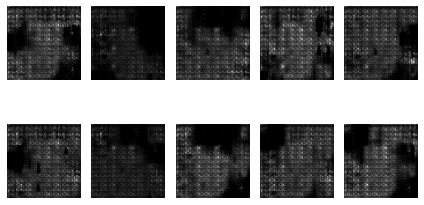

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.9234658181667328 GAN 1.0635647773742676
지금 epoch: 7


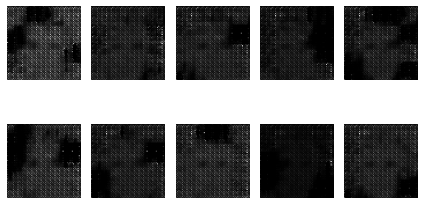

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.4982408583164215 GAN 1.8852251768112183
지금 epoch: 8


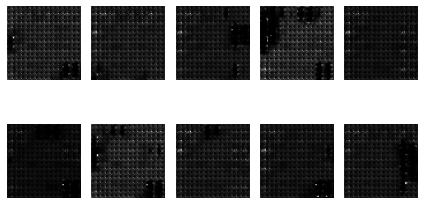

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.6624879539012909 GAN 1.3536968231201172
지금 epoch: 9


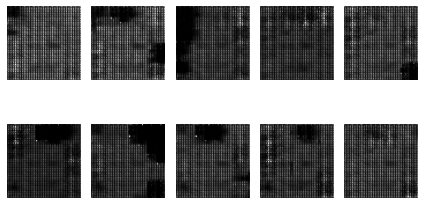

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.560280442237854 GAN 1.9832674264907837
지금 epoch: 10


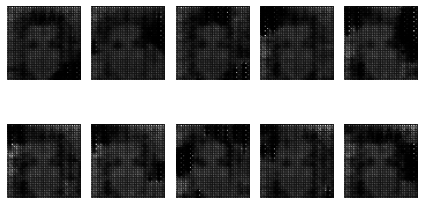

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.8955228328704834 GAN 1.4907467365264893
지금 epoch: 11


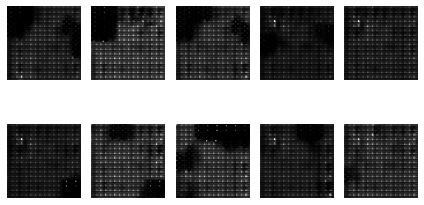

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.29805857688188553 GAN 2.8860018253326416
지금 epoch: 12


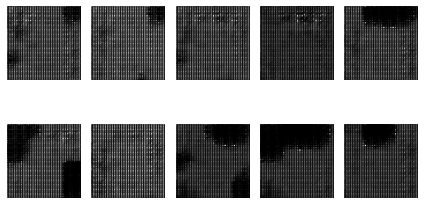

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.5762465000152588 GAN 0.720125675201416
지금 epoch: 13


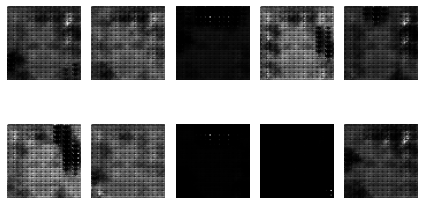

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.6600480377674103 GAN 1.6231296062469482
지금 epoch: 14


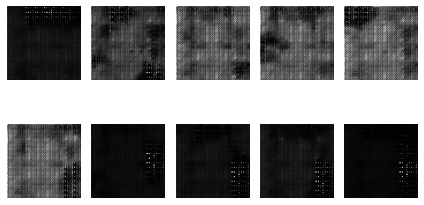

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.32364460825920105 GAN 1.1314444541931152
지금 epoch: 15


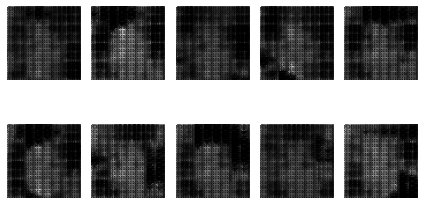

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.8717583119869232 GAN 1.2694214582443237
지금 epoch: 16


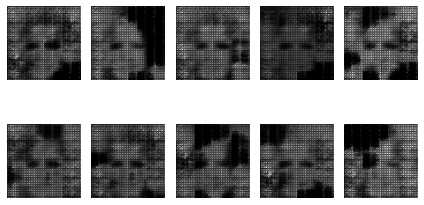

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 0.4185880571603775 GAN 1.535811424255371
지금 epoch: 17


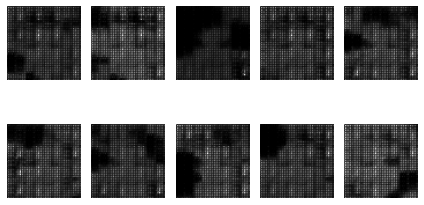

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.9912246465682983 GAN 0.649067223072052
지금 epoch: 18


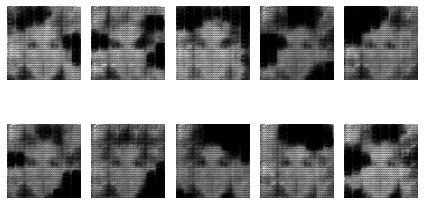

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.700926959514618 GAN 0.5927811861038208
지금 epoch: 19


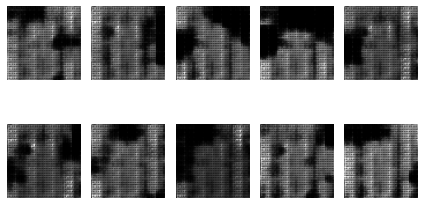

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 2.041070342063904 GAN 0.6051163673400879
지금 epoch: 20


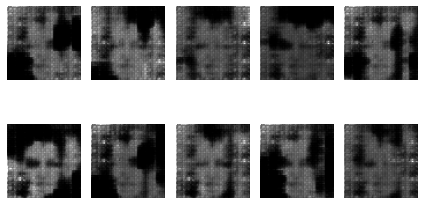

지금 batch: 0
지금 batch: 100
지금 batch: 200
지금 batch: 300
이번 epoch의 최종 loss는 Discrimiarot 1.3724068999290466 GAN 0.8020457029342651
지금 epoch: 21


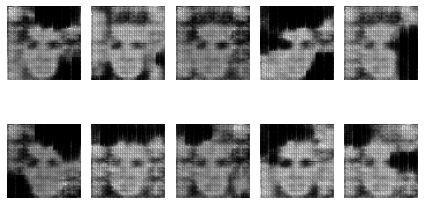

지금 batch: 0
지금 batch: 100
지금 batch: 200


In [ ]:
X_data = images
# epoch
for j in range(300):
  print(f'지금 epoch: {j}')
  predict_pic()

  for i in range(50000//128):
    if i % 100 ==0:
      print(f'지금 batch: {i}')
    # discriminator 트레이닝
    # 진짜 사진
    correct_img = X_data[i*128:(i+1)*128]
    mark1 = np.ones(shape=(128,1))
    loss1 = discriminator.train_on_batch(correct_img,mark1)


    # 가짜 사진
    rand_num = np.random.uniform(-1,1, size = (128,100) ) 
    wrong_img = generator.predict(rand_num)
    mark0 = np.zeros(shape=(128,1))
    loss2 = discriminator.train_on_batch(wrong_img,mark0)

    # generaotr 트레이닝
    rand_num = np.random.uniform(-1,1, size = (128,100) ) 
    mark1 = np.ones(shape=(128,1))
    loss3 = GAN.train_on_batch(rand_num,mark1)

  print(f'이번 epoch의 최종 loss는 Discrimiarot {loss1+loss2} GAN {loss3}')